# DSCI 572 Lab 2
<!-- rubric={mechanics:3} -->


## Before starting

You'll first need to install Keras and the TensorFlow backend, which should be possible with

```
pip install tensorflow
pip install keras
```

You can check that it's working by importing Keras below. If all is well, it should import successfully and print 
```
Using TensorFlow backend.
```

In [ ]:
import keras

## Exercise 1: small digits


The code below loads the digits data (used in previous courses/labs) and fits the follow models:

- KNN
- random forest
- SVM
- logistic regression
- 3-layer neural network 

Attribution: neural network code below adapted from the [Keras MNIST example](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py).

Note: this is a classification problem, and we won't talk about neural networks for classification until Thursday. However, this exercise does not require understanding the details of how NN classification works; it's just a matter of running the code.

Warning: Now that we're doing some heavy-duty computations, it's possible that Keras will cause your system to hang. If this happens, I suggest (i) moving the Keras code outside of Jupyter into a regular `.py` file and (ii) saving your work frequently.

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits['data'], digits['target'], test_size=0.33, random_state=1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1203 train samples
594 test samples


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


classifiers = {
    'knn'           : KNeighborsClassifier(),
    'random forest' : RandomForestClassifier(),
    'SVM'           : SVC(C=100),
    'logistic reg'  : LogisticRegression() 
}

for classifier_name, classifier_obj in classifiers.items():
    print(classifier_name)
    print("  Fitting...")
    classifier_obj.fit(X_train, y_train)
    print("  Evaluating...")
    pred_train = classifier_obj.predict(X_train)
    print("  Training accuracy: %f" % np.mean(pred_train==y_train))
    pred_test = classifier_obj.predict(X_test)
    print("  Test accuracy:     %f" % np.mean(pred_test==y_test))


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 50

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
# print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train accuracy: 1.0
Test accuracy: 0.979797979798


#### 1(a)
<!-- rubric={reasoning:2} -->

The optimization problem of training a neural network is non-convex. To explore this, try training
your network several times. You will get different results due to different random initializations and different randomness in the optimization method itself (see lecture 6). Discuss how the training/validation error changes across
runs, and also discuss how the model parameters themselves (the weights) change across runs (you'll need to think of a reasonable way of comparing the weights of two networks).
Do you observe substantially different models all with a similar prediction accuracy... or something different?

Note: to inspect the weights themselves, use the `get_weights()` function for the Keras Layer object. See [the documentation](https://keras.io/layers/about-keras-layers/) for more info. We also provide a function, below, that grabs all the weights of a trained model and puts them in one big numpy array:

In [ ]:
get_all_weights = lambda model: np.concatenate(tuple(map(lambda wi: wi.flatten(), model.get_weights())))

#### 1(b)
<!-- rubric={reasoning:1,code:1} -->

Keras designed its interface so that it plays nice with scikit-learn. To experience this, take one of your Keras models and pass it as the model into [sklearn's cross-validation score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). The basic syntax you need is below, but you can spice it up with different settings if you wish (the default is 3-fold cross validation). 

In [ ]:
def build_model():
    model = Sequential()
    # DO STUFF HERE like
    # model.add(...)
    # model.compile(...)
    return model

estimator = KerasClassifier(build_fn=build_model, verbose=0)
score = cross_val_score(estimator, X, y)

Is your cross-validation error similar to the validation error you got above using `train_test_split`?

## Exercise 2: big digits
<!-- rubric={reasoning:5,code:5} -->

Next, we'll move on to the famous the MNIST digits, which are more commonly used than that ones we've been previously using in DSCI 571 and 572. The data set is also bigger: the MNIST images are larger ($28\times28$ instead of $8\times8$) and there are more of them (60,000). In total, we're dealing with $60000\times28\times28\approx 47$ million training pixels instead of $1200\times8\times8\approx80000$ training pixels (about 600 times more training data and 200 times more test data). 

The following code loads the MNIST dataset. The first time you run it, the data will be downloaded. In future times, it will use the local version.

In [12]:
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


The code below runs a Keras model on the full MNIST data set. It's basically the same as the model above, but toned down a bit so that it runs more quickly. 

In [14]:
batch_size = 32
nb_classes = 10
nb_epoch = 5

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))

score = model.evaluate(X_train, Y_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Train accuracy: 0.992516666667
Test accuracy: 0.9804



Your tasks are as follows:

1. Which of the methods from Exercise 1 scales well to this larger data set? You are free to make arguments using theory (big-O running times) and/or experiment (timed runs) as you see fit. Keep in mind that we've increased both $N$ (number of examples) and $D$ (number of features). Don't subject yourself to experiments that take tens of minutes or hours. It is fine to declare defeat after a couple of minutes and say that a method doesn't scale. But, when that happens, try to say a little bit about why that might be the case. 
2. For those methods where the running time is reasonable (say, a couple minutes of computation), how does the accuracy compare between the methods?
3. For the neural network implemented with Keras above, explore the effects of the different hyperparameters on accuracy. In each case, discuss your results. Some things to try:
  - adding/removing layer(s)
  - changing the [activation functions](https://keras.io/activations/) from `relu` to `tanh`
  - adding [regularization](https://keras.io/regularizers/) such as dropout
  - changing the way the weights are [initialized](https://keras.io/initializations/)
  - changing the [optimizer](https://keras.io/optimizers/) from adam to something else, like SGD. Read the documentation and try changing the _parameters of the optimizer_ in addition to just the type of optimizer. It should not be difficult to completely mess up your training procedure, for example by tampering with the learning rate.

4. What network architecture/hyperparameters gave you the best validation accuracy? Which settings ended in complete disaster, if any? 

**NOTE: if at any point things are just way too slow, you can use a subset of the data to speed things up. But try to still draw interesting conclusions to the extent possible.**


## Exercise 3: pondering neural networks
<!-- rubric={reasoning:5} -->

Here are some quiz-type questions to get you thinking. 

1. Explain why a 1-layer (zero-hidden-layer) neural network with a linear activation is equivalent to linear regression. If you just wanted to do linear regression, what are the disadvantages of using Keras instead of a package like `lm`?
2. Consider a regression problem with $d=500$ features. You use a 2-hidden-layer neural network with hidden layer sizes $100$ and $200$. How many parameters does the model have? 
3. Name one advantage and one disadvantage of stochastic gradient descent, when comparing it to gradient descent?
4. Hyperparameter optimization would be easy if we could independently tune each hyperparameter. Then, with $m$ hyperparameters, we'd just have $m$ one-dimensional optimization problems. However, in reality the hyperparameters interact, which leaves you with the more daunting $m$-dimensional optimization problem. Consider for example a regularization hyperparameter (like dropout) and an architecture parameter (like the number of units or layers). Why do you think these hyperparameters would interact with each other? What combinations do you think might lead to better or worse performance? 

<br><br>

-------------

FYI: this is the line between the first half (lectures 5 and 6) and the second half (lectures 7 and 8) of the lab. 

-------------

<br><br>

In [1]:
import numpy as np
from scipy.misc import imresize
from scipy.signal import convolve2d
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 4: convolutions

For each of the filters given below, convolve the given image (or a different image of your choice) with the given filter and discuss why the results look the way they do. 

To load an image into Python, you can the same approach as in DSCI 512 lab 4, namely

        import skimage.io
        img = skimage.io.imread(FILENAME)

You can perform 2D convolutions using [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.convolve2d.html).

The suggested image size is around 100x100 pixels; if the image is too big, it will be hard to see the changes by eye using the very small filters given below. If you want to make an image smaller, try [scipy.misc.imresize](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imresize.html). This will be a lot faster than seam carving :)

In [9]:
def preprocess_image(filename):
    img = imread(filename) # read in the image
    img = imresize(img, (100,100)) # resize it if you want
    return rgb2gray(img) # make it grayscale

def show_conv(img, filt):
    plt.figure()
    plt.subplot(1,2,1)
    imshow(img)
    plt.title("original")
    I_filt = convolve2d(img,filt, boundary='symm', mode='same')
    I_filt = np.maximum(0, I_filt) # set negative values to 0, for visualization purposes
    I_filt = np.minimum(1, I_filt) # set values greater than 1 to 1, for visualization purposes
    plt.subplot(1,2,2)
    if np.sum(filt) == 0: # a trick to make the images easier to see, not part of the "math"
        imshow(I_filt/np.max(I_filt))
    else:
        imshow(I_filt)
    plt.title("filtered")
    return I_filt

#### 4(a) - an example, you don't need to do this one

(1, 10)
[[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]


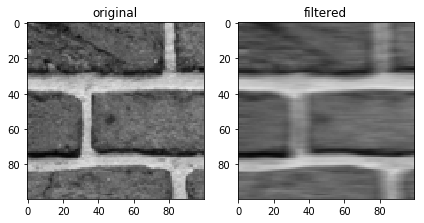

In [10]:
ft1 = 0.1*np.ones(10)[None]
print(ft1.shape)
print(ft1)
img = preprocess_image("bricks_smaller.jpg")
res2 = show_conv(img, ft1)

** Example answer for part (a) above: **
 the filter `ft1` has shape $1\times 10$, meaning it's a horizontal bar all containing $0.1$. Therefore I would expect a blurring in the horizontal direction, meaning the _vertical_ edges get blurred (because these are the ones that change rapidly in the horizontal direction). This seems to be happening in the result. 

#### 4(b)
<!-- rubric={reasoning:1} -->

(10, 1)
[[ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]]


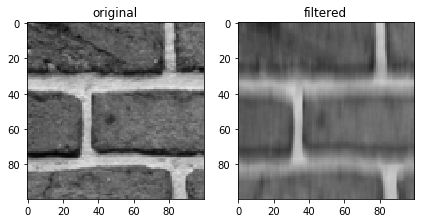

In [11]:
ft2 = ft1.T
print(ft2.shape)
print(ft2)
res2 = show_conv(img, ft2)

#### 4(c)
<!-- rubric={reasoning:1} -->

(1, 3)
[[-0.5  1.  -0.5]]


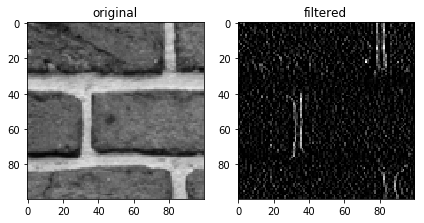

In [12]:
ft3 = np.array([-0.5, 1, -0.5])[None]
print(ft3.shape)
print(ft3)
res3 = show_conv(img, ft3)

#### 4(d)
<!-- rubric={reasoning:1} -->

(3, 1)
[[-0.5]
 [ 1. ]
 [-0.5]]


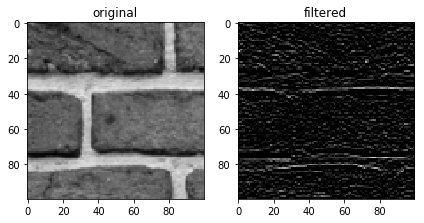

In [13]:
ft4 = ft3.T
print(ft4.shape)
print(ft4)
res4 = show_conv(img, ft4)

#### 4(e)
<!-- rubric={reasoning:1} -->

(10, 10)


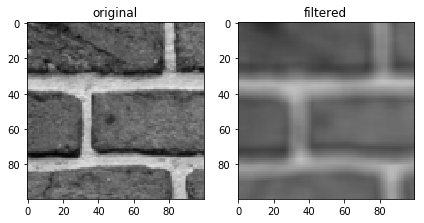

In [14]:
ft5 = 0.01*np.ones((10,10))
print(ft5.shape)
res5 = show_conv(img, ft5)

#### 4(f)
<!-- rubric={reasoning:1} -->

(3, 3)
[[-0.125 -0.125 -0.125]
 [-0.125  1.    -0.125]
 [-0.125 -0.125 -0.125]]


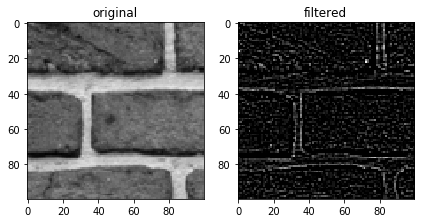

In [15]:
ft6 = -np.ones((3,3))/8
ft6[1,1] = 1
print(ft6.shape)
print(ft6)
res6 = show_conv(img, ft6)

### (optional, but not onerous) 4 - reflection
<!-- rubric={reasoning:1} -->

Earlier in this course we talked about gradients (lecture 2) and numerical differentiation (lecture 4). Think about parts (c), (d) and (f) above, which are the "edge detectors". Do these have anything to do with the topics from earlier on? Can you relate these edge detection operations to "derivatives" or "gradients"?

Also, by the way, back in the seam carving lab of DSCI 512 I gave you a function that calculated the "energy" of an image, and we then looked for low energy seams. Here's the code I gave you, reproduced below:

In [16]:
from scipy.ndimage.filters import convolve

def energy(image): 
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)

There's no particular reason I switched from [`scipy.ndimage.filters.convolve`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html) to [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.convolve2d.html); they perform the same function for our purposes. I thought you might enjoy looking back at this formerly mysterious code with your newfound knowledge. And it's also a bit of a hint: the seam carving energy function looked for "edges" or "changes" or ... derivatives! The above actually calculates the magnitude of the "gradient" at every point. The whole thing should make sense now as well -- when seam carving we wanted to remove pixels where there wasn't much going on in the immediate vicinity.

## Exercise 5. Convolutional networks for MNIST

Sorry to continue with MNIST so long. It's just _THE_ classic data set for this stuff.


#### 5(a) 
<!-- rubric={reasoning:2} -->

Back when we did handwritten digits in DSCI 571, and even earlier on in this course, we did something quite silly: we "flattened" the images into vectors; for example $28\times 28$ MNIST images became vectors of length 784. This is arguably insane! We were completely discarding the "spatial information" contained in the image and just pretended we had 784 different features. Briefly discuss how, with convnets, we avoid throwing away this information.

#### 5(b) 
<!-- rubric={reasoning:2} -->

Below is some code that trains a convnet on MNIST. The code is adapted from the book [Deep Learning with Python](https://machinelearningmastery.com/deep-learning-with-python2/) with permission from the author. 

In [2]:
# Code 
# Simple CNN for the MNIST Dataset

import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Using TensorFlow backend.


In [3]:
# take a subset of the data for speed
subset_size = 10000
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]


# define a simple CNN model
model = Sequential()
model.add(Convolution2D(32, 5, 5, input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 24, 24, 32)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 12, 12, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 12, 12, 32)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 4608)          0           dropout_1[0][0]                  
___________________________________________________________________________________________

In [5]:
for w in model.get_weights():
    print(w.shape)

(5, 5, 1, 32)
(32,)
(4608, 128)
(128,)
(128, 10)
(10,)


In [ ]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))


The code above shows that the model has 592,074 parameters. Explain where this number comes from by going layer by layer and accounting for all the parameters.

#### 5(c) 
<!-- rubric={reasoning:5} -->

As in the earlier part of the lab, play around with some of the hyperparameters and see if you can get better performance. Discuss your results and compare them with the fully connected network you used last time. 

#### (optional, but not onerous) 5(d) 
<!-- rubric={reasoning:1} -->

In the code above, the data is transformed to `float32` type. In lecture 3 we discussed floating point representations. The main advantage of using 32-bit floating point numbers (versus 64-bit) is computational speed, but there's a disadvantage in terms of accuracy. Think about dropout and what it does/accomplishes. Did thinking about dropout alleviate your concerns about the potential pitfalls of using a smaller floating point represntation? Briefly discuss.

## Exercise 6. Doing it on AWS
<!-- rubric={reasoning:1} -->

You will now deploy TensorFlow on the cloud using AWS. This will allow you to rent GPUs on AWS and assess the benefits of training networks on GPUs.

** Warning: since this involves using EC2, I suggest doing this part when you have an hour or so to dedicate, so that you can get it done all at once and then terminate your instance (to stop paying) **

#### 6(a) launch a spot instance on AWS

Due to the high cost associated with the AWS GPU instances, we highly recommend that you make "spot request" for the GPU instances to complete this exercise. AWS "spot instances" are cheaper than dedicated instances, but the catch is that you might be kicked off at any time if a higher-paying customer comes along. Here are some facts about spot-instances:

- On-demand pricing for `g2.2xlarge` (the smaller of the two GPU instance types available at AWS) is \$0.702 per hour. The average spot price for the same instance is about \$0.127 per hour (see the pricing for spot instances [here](https://aws.amazon.com/ec2/spot/pricing/)).
- A further discount is available for previous generation GPU instances, where the on-demand price for [`cg1.4xlarge`](https://aws.amazon.com/ec2/previous-generation/) is \$2.1 per hour but the spot instance price is about \$0.07 per hour on average.

For the purposes of this exercise, you will only be using GPU instances on a moderately sized dataset and so you won't be using the GPUs for very long. Hence, there is very little need to worry about your instance terminating without warning.


Follow these steps to activate AMI:

1. Go to https://aws.amazon.com/marketplace/pp/B01EYKBEQ0
2. Press "continue"
3. Sign in
4. Press "Manual Launch" (because the regular launch doesn't seem to allow us to use spot instances, which are much cheaper)
5. Scroll dowsn and copy the AMI id for the region you're at (make sure it's not the Canada one, which doesn't have GPUs; we suggest Virginia). Save this AMI id, you'll need it soon.
6. Press "Acecpt Software Terms"

Next, follow these steps to launch an EC2 GPU instance via spot request:

1. Log in to [AWS console](https://console.aws.amazon.com/). Set the region to US East (N. Virginia).
2. Click on EC2. Then, click on **Spot Requests** on the left panel.
3. Click on **Request Spot Instances** button in blue.
4. Choose **Search for AMI** and enter the AMI id from before, selcting "Community AMIs" from the Dropdown.  
5. Press the **Select** button to choose an **Instance type(s)**.
     + Filter for GPU instances (note: the "Canada" AWS region doesn't have GPUs, use a U.S. one).
     + The recommended choices are: `p2.xlarge`, `g2.2xlarge`, or `cg1.4xlarge`. You can pick arbitrarily or compare the prices. I used `p2.xlarge`.
       - `cg1.4xlarge` is an older generation GPU instance and we have experienced some speed issues with this instance so it may be best to use the other two instances as long as the price is reasonable (say \$0.5).
       - If you want, click on **Pricing History** button to see the movement in the prices up to the past 3 months. 
6. Scroll down to **Maximum price**, and set the max prices you are willing to pay. Any value $\leq$ \$0.7 is reasonable for this exercise. Check to ensure that the current spot instance price is below the max price you are willing to pay. In a rare chance that the current price is set high (similarly high as the on-demand prices), you will have to wait until the price settles down to the "normal" level, or try a different instance type of maybe a different region.
7. Click on **Next** button. In the next page,
     + click on the **Attach at launch** checkbox
     + Depending on the instance type that you are launching, checking the EBS optimized box is recommended (it is included in `p2.xlarge`). For further details, see [here](http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EBSOptimized.html). I don't think it really matters much if you check this box or not, but maybe it'll speed things up.
     + ensure that correct keypair is specified (if you don't have one, see the DSCI 525 lab for instructions. You can do it under "Security groups" at the left-hand size. Remember to `chmod 400` on your key `.pem` file and to open port 22 and to ssh with `-i` linking to your key file)
     + Review your settings and submit the spot request.
8. Wait for your request to be accepted, and your instance to launch.
    + Access your instance via terminal using SSH. Recall that you had to do this for DSCI 525: opening the port 22 for SSH traffic from either your computer IP or anywhere. From the console click "Instances" on the left, then scroll down and select "default" under "security groups", then inbound, edit, add rule, SSH port 22 from "my IP".

**You are now paying an hourly fee for your instance. Ideally you should do the below all in one sitting (it hopefully won't take too long). Make sure to terminate the instance when finished. There is another reminder below in large font. **

You can also run the AMI through a local Jupyter notebook, following [these instructions](https://github.com/bitfusionio/amis/wiki/Bitfusion-Boost-Ubuntu-14-Tensorflow-AMI#jupyter-notebook---http-ec2-instance-public-ip-8888). I tried this and it works great -- very convenient. I just copy/pasted in the Python code and trained the models in Jupyter. You don't have to do this but it may make your experience better and takes less than a minute to set up. The instructions reference a public IP, which you can get from the EC2 console by clicking on your instance and looking for the "IPv4 Public IP" at the bottom of the screen.

<br>
Deliverable: Submit a screenshot that shows you successfully launched an instance.

#### 6(b) run experiments on the GPU
<!-- rubric={reasoning:4} -->

Run the same MNIST experiment as above but on AWS with the GPU. You should be able to use the full data set now (you'll notice the code above takes only a subset of 10,000 training examples -- you should use the full data set on AWS). 

Report your performance after 10 epochs when training on the full data set. How does it compare to the best validation error you were able to get on your local machine (which presumably required using a subset of the data to run in reasonable time)? 


#### 6(c) GPU vs. CPU
<!-- rubric={reasoning:2} -->

TensorFlow will automatically use the GPU if it is available. This is the mean reason the training (presumably) runs so much faster on the EC2 instance than your local machine. To quantify this difference, we can explicitly disable the GPU on our EC2 training. To explicitly disable the GPU, create your model using `with tf.device('/cpu:0')` scope (see example below). 

Compare the validation accuracy you get after about 1 minute of training in each case (GPU vs. CPU). 

(Note: this doesn't matter here, but just FYI, with the Theano backend rather than the TensorFlow backend, you use a different method for forcing it to use the CPU, which is the [Theano config file](http://deeplearning.net/software/theano/library/config.html).)

In [21]:
# example
import tensorflow as tf
with tf.device('/cpu:0'):
    pass # do your Keras stuff in here to run on the CPU
    # I believe only the model specification actually needs to be here but I don't
    # see any harm in putting the calls to `compile()` and `fit()` here too.
    

#### (optional) 6(d)  TensorFlow vs. Theano
<!-- rubric={reasoning:2} -->

Compare the speed/accuracy of TensorFlow vs. Theano with your experiments. To switch backends, modify the Keras config file: `~/.keras/keras.json`. When you `import keras` in Python it tells you which backend it is using, so you will be able to verify that you successfully switched backends. 

#### (optional, silly) 6(e): how hot can you make your GPU?

Note: this is not worth any bonus points, it's just for fun.

If you type `nvidia-smi` in the terminal of your EC2 instance, you'll see some output about the status of the GPU, including its temperature in Celsius. What is the GPU temperature "at rest"? How hot can you make the GPU by asking it to crunch a lot of numbers?

Sillyness aside, the information in `nvidia-smi` is very useful to see what's going on with your GPUs. You can also type something like

```
watch -n 1 nvidia-smi
```
so that it stays open and updates every 1 second. Then use `ctrl-c` to get out of it. 


# Exercise 6(f): TERMINATE ALL OF YOUR EC2 INSTANCES!!!

Don't forget to do this or you will be incurring charges!!! **The MDS program will not reimburse you for charges incurred because you forgot to terminate your instances.**

If for some reason you aren't terminating your instances right now, please create some reminders for yourself!! You can do, in Slack,
```
/remind me "TERMINATE MY EC2 INSTANCES" tomorrow
```
just for example. Or set a calendar reminder. 

## Exercise 7: reflection
<!-- rubric={reasoning:5} -->

Answer the following questions:

1. If you had access to 1000 GPUs, could you get 1000x performance? If not, why? What are the limitations/bottlenecks?
2. What are the pros/cons of neural nets, vs. approaches previously learned (for both regression and classification)? Choose one method from a previous course (561, 562, 571) and compare it with what you've done in deep learning. Write a paragraph summarizing the results.
3. What was one particularly fun/interesting aspect of DSCI 572? What was one particularly tedious/uninteresting aspect of DSCI 572?